In [1]:
import pandas as pd

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
DIRECTORY_PATH = '/home/semarm/embeddings-leis/'
bs=32

In [6]:
torch.cuda.set_device(1)

In [7]:
home_dir = Path(DIRECTORY_PATH)
data_dir = Path('/home/semarm/embeddings-leis/data')
models_dir = Path("/home/semarm/embeddings-leis/models")
# home_dir.ls()

# Preparing language model dataset

In [8]:
df_lm = pd.read_csv(data_dir/"justifications.csv", sep = '|')

In [9]:
df_lm.head()

,Unnamed: 0,file_name,id,numero,tipo,previous,justification,full_text
0,0,471150_7039_PL.pdf,471150,7039,PL,"PROJETO DE LEI No\n\n, DE 2010\n\n(Do Sr. Feli...",NaN,"PROJETO DE LEI No\n\n, DE 2010\n\n(Do Sr. Feli..."
1,0,607812_13_REQ.pdf,607812,13,REQ,CAMARA DOS DEPUTADOS\n\nCOMISSAO DE ESPORTE -C...,A imprensa tem divulgado cada vez com mais fre...,CAMARA DOS DEPUTADOS\n\nCOMISSAO DE ESPORTE -C...
2,0,1618524_80_REQ.pdf,1618524,80,REQ,REQUERIMENTO No de 2015\n(Do Sr. Pedro Cunha L...,NaN,REQUERIMENTO No de 2015\n(Do Sr. Pedro Cunha L...
3,0,2080653_254_REQ.pdf,2080653,254,REQ,COMISSAO PARLAMENTAR DE INQUERITO DESTINADA IN...,NaN,COMISSAO PARLAMENTAR DE INQUERITO DESTINADA IN...
4,0,2175138_8638_REQ.pdf,2175138,8638,REQ,"REQUERIMENTO No\n\n, DE 2018\n\n(da Sra. JESSI...",NaN,"REQUERIMENTO No\n\n, DE 2018\n\n(da Sra. JESSI..."


In [10]:
df_lm = df_lm.fillna('')
df_lm['id'] = df_lm['numero'].map(str) + df_lm['tipo']
# df_lm['full_text'] = df_lm['texto_anterior'] + df_lm['justificativa']

In [11]:
df_lm.shape

(96400, 8)

In [12]:
data_lm = (TextList.from_df(df_lm, cols="full_text")
           .split_by_rand_pct(0.2)
           .label_for_lm()
           .databunch(bs=bs, num_workers=8))
#               .add_test(TextList.from_df(df_test, cols=['text'])) 
# data_lm
len(data_lm.vocab.itos),len(data_lm.train_ds), data_lm

(60000, 77120, TextLMDataBunch;
 
 Train: LabelList (77120 items)
 x: LMTextList
 xxbos xxup camara xxup dos xxup deputados 
  
   xxup comissao xxup de xxup esporte xxup xxunk 
   xxup requerimento 
   ( xxmaj do xxmaj sr . xxup andre xxup figueiredo - xxup pdt / xxup ce ) 
  
   xxmaj requer que seja convidado o 
   relator - geral das obras da xxmaj copa no 
   xxmaj tribunal de xxmaj contas da xxmaj uniao ( xxup tcu ) , 
   ministro xxmaj valmir xxmaj campelo , a fim de 
   apresentar os resultados parciais 
   das medidas ja adotadas e em 
   andamento na fiscalizacao das 
   obras de mobilidade urbana e de 
   reforma 
   e 
   ampliacao 
   dos 
   aeroportos das cidades - sedes da 
   xxmaj copa do xxmaj mundo . 
  
   xxmaj senhor xxmaj presidente , 
  
   xxmaj nos termos do art . 255 do xxmaj regimento xxmaj interno , requeremos a xxmaj vossa 
   xxmaj excelencia , ouvido o xxmaj plenario desta xxmaj comissao , a realizacao de audiencia publica , 
   em data a ser agendada ,

In [13]:
wiki_weights_fns = ['/home/semarm/embeddings-leis/POC/export_POC/models/wiki_model_10epochs', "/home/semarm/embeddings-leis/POC/export_POC/models/wiki_vocab_10epochs"]

In [15]:
perplexity = Perplexity()
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, 
                                  pretrained_fnames=wiki_weights_fns,
                                  metrics=[accuracy, perplexity]).to_fp16()

# Training language model

epoch,train_loss,valid_loss,accuracy,perplexity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 2.51E-02


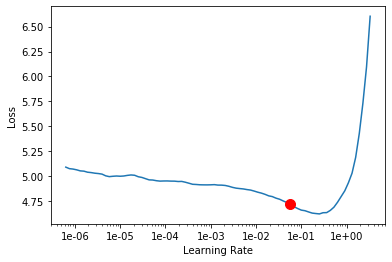

In [16]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)

In [17]:
lr = 2e-2
learn_lm.freeze()
learn_lm.fit_one_cycle(3, max_lr=lr,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.415649,3.449173,0.377596,31.474344,22:21
1,3.240868,3.142526,0.407374,23.162228,22:14
2,3.041761,2.887373,0.440050,17.946167,22:19


In [19]:
learn_lm.freeze_to(-2)
learn_lm.fit_one_cycle(2, max_lr=lr/2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.830916,2.890176,0.453481,17.996393,22:29
1,2.755568,2.570702,0.500022,13.075009,22:40


In [22]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(3, max_lr=lr/(2.6**4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.460554,2.469124,0.516122,11.812061,25:13
1,2.444366,2.378021,0.531716,10.783536,25:49
2,2.296562,2.340804,0.538574,10.389561,25:48


In [25]:
learn_lm.fit_one_cycle(5, max_lr=lr/2.6**4, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.327016,2.368345,0.534373,10.679733,25:01
1,2.328033,2.347482,0.537705,10.459194,25:28
2,2.334678,2.305523,0.545243,10.029424,25:54
3,2.259288,2.265101,0.552642,9.632057,25:15
4,2.121357,2.251791,0.554994,9.504732,25:51


In [28]:
learn_lm.save(models_dir/'language_model_learner')

In [29]:
learn_lm.save_encoder('/home/semarm/embeddings-leis/models/language_model_enc')

# Preparing classification dataset

In [16]:
df_clas = pd.read_csv("../data/proposicoesTemas.csv", sep=';')
df_clas = df_clas.dropna(subset=['numero'])
df_clas['id'] = df_clas['numero'].astype(int, errors='ignore').map(str) + df_clas['siglaTipo']
df_clas.head()

,uriProposicao,siglaTipo,numero,ano,codTema,tema,relevancia,id
0,https://dadosabertos.camara.leg.br/api/v2/prop...,MPV,921.0,2020.0,70,Finanças Públicas e Orçamento,0,921MPV
1,https://dadosabertos.camara.leg.br/api/v2/prop...,MPV,921.0,2020.0,56,Saúde,0,921MPV
2,https://dadosabertos.camara.leg.br/api/v2/prop...,PL,1600.0,2020.0,44,Direitos Humanos e Minorias,0,1600PL
3,https://dadosabertos.camara.leg.br/api/v2/prop...,PL,1600.0,2020.0,66,"Indústria, Comércio e Serviços",0,1600PL
4,https://dadosabertos.camara.leg.br/api/v2/prop...,PL,1600.0,2020.0,56,Saúde,0,1600PL


In [17]:
df_clas['tema'].unique()

array(['Finanças Públicas e Orçamento', 'Saúde', 'Direitos Humanos e Minorias', 'Indústria, Comércio e Serviços',
       'Homenagens e Datas Comemorativas', 'Administração Pública', 'Defesa e Segurança',
       'Previdência e Assistência Social', 'Relações Internacionais e Comércio Exterior', 'Educação', 'Comunicações',
       'Turismo', 'Direito e Defesa do Consumidor', 'Economia', 'Ciência, Tecnologia e Inovação',
       'Viação, Transporte e Mobilidade', 'Arte, Cultura e Religião', 'Direito Penal e Processual Penal',
       'Cidades e Desenvolvimento Urbano', 'Agricultura, Pecuária, Pesca e Extrativismo',
       'Energia, Recursos Hídricos e Minerais', 'Direito Civil e Processual Civil', 'Direito e Justiça',
       'Trabalho e Emprego', 'Esporte e Lazer', 'Processo Legislativo e Atuação Parlamentar',
       'Meio Ambiente e Desenvolvimento Sustentável', 'Estrutura Fundiária', 'Política, Partidos e Eleições',
       'Direito Constitucional', 'Ciências Exatas e da Terra', 'Ciências So

In [18]:
df = pd.merge(df_lm, df_clas, on=['id'] )
print(df.shape)

(256234, 15)


In [19]:
df = df.drop(columns=['ano', 'uriProposicao'])

In [20]:
df.tail()

,Unnamed: 0,file_name,id,numero_x,tipo,previous,justification,full_text,siglaTipo,numero_y,codTema,tema,relevancia
256229,0,2169837_9842_PL.pdf,9842PL,9842,PL,"PROJETO DE LEI No\n\n, DE 2018\n\n(Do Sr. ANDR...",,"PROJETO DE LEI No\n\n, DE 2018\n\n(Do Sr. ANDR...",PL,9842.0,41,Cidades e Desenvolvimento Urbano,0
256230,0,2169837_9842_PL.pdf,9842PL,9842,PL,"PROJETO DE LEI No\n\n, DE 2018\n\n(Do Sr. ANDR...",,"PROJETO DE LEI No\n\n, DE 2018\n\n(Do Sr. ANDR...",PL,9842.0,61,"Viação, Transporte e Mobilidade",0
256231,0,2183002_10727_PL.pdf,10727PL,10727,PL,"PROJETO DE LEI No\n\n, DE 2018\n\n(Do Sr. CABO...",,"PROJETO DE LEI No\n\n, DE 2018\n\n(Do Sr. CABO...",PL,10727.0,57,Defesa e Segurança,0
256232,0,2181863_10631_PL.pdf,10631PL,10631,PL,"PROJETO DE LEI No\n\n, DE 2018\n\n(Do Sr. ARNA...",,"PROJETO DE LEI No\n\n, DE 2018\n\n(Do Sr. ARNA...",PL,10631.0,42,Direito Civil e Processual Civil,0
256233,0,2181863_10631_PL.pdf,10631PL,10631,PL,"PROJETO DE LEI No\n\n, DE 2018\n\n(Do Sr. ARNA...",,"PROJETO DE LEI No\n\n, DE 2018\n\n(Do Sr. ARNA...",PL,10631.0,44,Direitos Humanos e Minorias,0


In [21]:
df['id_tema'] = df['id'] + df['codTema'].map(str)
df = df.drop_duplicates(subset='id_tema')
df.shape

(83447, 14)

In [22]:
df['codTema'].value_counts()

34    7923
56    6280
44    5676
70    5454
58    4830
46    4798
40    3902
61    3892
43    3733
57    3596
66    3308
54    3074
48    2840
41    2771
37    2723
52    2632
42    2286
72    1997
67    1864
51    1506
74    1397
35    1255
39    1191
64    1167
55     908
62     780
53     636
76     436
60     417
68     171
86       3
85       1
Name: codTema, dtype: int64

In [177]:
df_final = df.copy()
df_final['target'] = ''
value_counts = df['codTema'].value_counts()
for idx in df_final['id'].unique():
#     print(idx)
    aux = df_final[df_final['id'] == idx]
#     print(aux)
    df_final.loc[df_final['id'] == idx, 'target'] = ' '.join(str(x) for x in aux['codTema'].unique() if value_counts[x] > 3000)
#     print(aux)
# #     themes = []
#     for i, line in aux.iterrows():
# #         print(line)
#         themes.append(line['codTema'])
# #     print(themes)
# #     print(aux)
# #     aux.iloc[0, -1] = [themes]
#     print(pd.Series([themes] * len(aux)))
#     print(aux)
#     print(aux)
#     break
#     if df_final is None:
#         df_final = aux
#     else:
#         df_final = pd.concat([df_final, aux])
# #     break

df_final = df_final.drop(['codTema', 'tema', 'id_tema'], axis=1)

In [178]:
df_final.shape

(83447, 12)

In [179]:
df_final = df_final.drop_duplicates(subset='id')
print(df_final.shape)
df_final.head()

(19129, 13)


,index,Unnamed: 0,file_name,id,numero_x,tipo,previous,justification,full_text,siglaTipo,numero_y,relevancia,target
0,0,0,471150_7039_PL.pdf,7039PL,7039,PL,"PROJETO DE LEI No\n\n, DE 2010\n\n(Do Sr. Feli...",,"PROJETO DE LEI No\n\n, DE 2010\n\n(Do Sr. Feli...",PL,7039.0,0,46 58 61 66
5,18,0,2204216_3045_PL.pdf,3045PL,3045,PL,"PROJETO DE LEI No\n\n, DE 2019\n\n(Do Sr. NELS...",,"PROJETO DE LEI No\n\n, DE 2019\n\n(Do Sr. NELS...",PL,3045.0,0,34 70 56 44 61
12,45,0,550428_4149_PL.pdf,4149PL,4149,PL,"PROJETO DE LEI No\n\n, DE 2012\n\n(Do Sr. Leon...",,"PROJETO DE LEI No\n\n, DE 2012\n\n(Do Sr. Leon...",PL,4149.0,0,56 34 58 46 57 44
21,72,0,969167_621_PL.pdf,621PL,621,PL,"PROJETO DE LEI No\n\n, DE 2015\n\n(Da Deputada...",,"PROJETO DE LEI No\n\n, DE 2015\n\n(Da Deputada...",PL,621.0,0,44 46 43 58 54 70
30,102,0,593145_6411_PL.pdf,6411PL,6411,PL,"PROJETO DE LEI No\n\n, DE 2013\n\n(Do Sr. CARL...",,"PROJETO DE LEI No\n\n, DE 2013\n\n(Do Sr. CARL...",PL,6411.0,0,44 58 43 34 57


In [189]:
import numpy as np

# df_final = df_final.reset_index()
idx = np.random.permutation(df_final.shape[0])
split_point = int(df_final.shape[0] * 0.8)
split_point
train_idx, test_idx = idx[:split_point], idx[split_point:]
df_final['is_valid'] = False
for i, line in df_final.iterrows():
#     print(line)
    if i in test_idx:
        df_final.loc[df_final["id"] == line['id'], 'is_valid'] = True

df_final['is_valid'].sum()

3826

In [191]:
df_final.shape
df_final.to_csv("df_final.csv")

In [95]:
bs=128
data_class = (TextList.from_df(df_final, cols="full_text", vocab=data_lm.vocab)
              .split_from_df("is_valid")
              .label_from_df(cols='target', label_delim=' ')
              .databunch(bs=bs, num_workers=8))
#               .add_test(TextList.from_df(df_test, cols=['text'])) 
data_class

TextClasDataBunch;

Train: LabelList (15303 items)
x: TextList
xxbos xxup projeto xxup de xxup lei xxmaj no 
 
  , xxup de 2010 
 
  ( xxmaj do xxmaj sr . xxmaj felipe xxmaj bornier ) 
 
  xxmaj altera a xxmaj lei no 9.503 , de 1997 , que 
  institui o xxmaj codigo de xxmaj transito xxmaj brasileiro , para 
  dispor sobre a composicao das xxmaj juntas 
  xxmaj administrativas de xxmaj recursos de xxmaj infracoes - 
  xxup jari . 
 
  o xxmaj congresso xxmaj nacional decreta : 
 
  xxmaj art . 1o xxmaj esta xxmaj lei acrescenta paragrafo ao art . 16 da xxmaj lei no 
  9.503 , de 23 de setembro de 1997 , para dispor sobre a composicao das xxmaj juntas 
  xxmaj administrativas de xxmaj recursos de xxmaj infracoes - xxup jari . 
  xxmaj art . 2o o art . 16 da xxmaj lei no 9.503 , de 1997 , passa a vigorar 
  acrescido do seguinte xxup ss 2o , renumerando - se o atual paragrafo unico para xxup ss 1o : 
  " xxmaj art . 16 . xxrep 79 . 
  xxrep 93 . 
  xxup ss 2o xxmaj os membros das xxup jar

In [96]:
data_class.show_batch()

text,target
"xxbos xxup medida xxup provisoria xxmaj no 667 , xxup de 2 xxup de xxup janeiro xxup de 2015 \n xxmaj abre credito extraordinario , em favor dos orgaos e \n empresas estatais , constantes do xxmaj projeto de xxmaj lei \n xxmaj orcamentaria de 2015 , no valor de xxup r$ \n xxunk , para os fins que especifica . \n \n a xxup",70
"xxbos xxup medida xxup provisoria xxmaj no 568 , xxup de 11 xxup de xxup maio xxup de 2012 . \n \n xxmaj dispoe sobre servidores do xxmaj instituto xxmaj nacional de \n xxmaj meteorologia , da xxmaj comissao xxmaj executiva do xxmaj plano da xxmaj lavoura \n xxmaj cacaueira , da xxmaj agencia xxmaj brasileira de xxmaj inteligencia , da \n xxmaj comissao de xxmaj",34
"xxbos xxup projeto xxup de xxup lei no \n \n / 2018 \n \n xxmaj da nova redacao ao art . 4o , da xxmaj lei no 13.165 , de 29 de setembro de 2015 , \n que alterou o art . xxup 233-a , da xxmaj lei no 4.737 , de 15 de julho de 1965 - xxmaj codigo \n xxmaj eleitoral , no sentido",
"xxbos xxup projeto xxup de xxup lei \n xxmaj cria , transforma e extingue cargos e funcoes , \n reestrutura cargos e carreiras , altera a remuneracao \n de servidores , altera a remuneracao de militares de \n ex - xxmaj territorios xxmaj federais , altera disposicoes sobre \n gratificacoes de desempenho , dispoe sobre a \n incidencia de contribuicao previdenciaria facultativa \n",34;58
"xxbos xxup medida xxup provisoria xxmaj no 805 , xxup de 30 xxup de xxup outubro xxup de 2017 \n \n xxmaj posterga \n ou \n cancela \n aumentos \n remuneratorios \n para \n os \n exercicios \n o \n subsequentes , altera a xxmaj lei n 8.112 , de 11 de \n dezembro de 1990 , que dispoe",34


In [ ]:
# from fastai.metrics import APScoreMulti, RecallMulti
acc_02 = partial(accuracy_thresh, thresh=0.25)
f_score = partial(fbeta, thresh=0.25)

learn_c = text_classifier_learner(data_class,
                                  AWD_LSTM,
                                  metrics=[acc_02, f_score]).to_fp16()

learn_c.load_encoder(home_dir/'models/language_model_enc')
learn_c.model


# Training classificator

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 7.59E-02


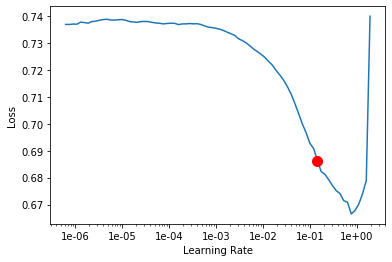

In [23]:
learn_c.lr_find()
learn_c.recorder.plot(suggestion=True)

In [24]:
lr = 4e-2
learn_c.freeze()
learn_c.fit_one_cycle(3, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.557240,0.532641,0.670472,0.418574,02:18
1,0.533876,0.521549,0.580109,0.516363,02:21
2,0.527758,0.517376,0.570916,0.536661,02:33


In [25]:
learn_c.unfreeze()
learn_c.fit_one_cycle(5, lr/(2.6**4), moms=(0.6,0.4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.521186,0.508391,0.593790,0.532461,03:01
1,0.510426,0.494477,0.652942,0.486049,02:52
2,0.497142,0.476184,0.676121,0.501940,03:03
3,0.484988,0.471909,0.667160,0.526678,03:04
4,0.483256,0.471714,0.670965,0.523939,02:56


In [26]:
learn_c.fit_one_cycle(4, lr/(2.6**4), moms=(0.6,0.4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.478463,0.471869,0.642021,0.551651,02:56
1,0.475669,0.462780,0.672084,0.538845,02:47
2,0.469619,0.456946,0.677501,0.548528,02:56
3,0.464927,0.456517,0.677428,0.550299,02:48


In [27]:
learn_c.fit_one_cycle(4, lr/(2.6**4), moms=(0.6,0.4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.461489,0.454799,0.686926,0.546890,03:03
1,0.461350,0.453655,0.680434,0.563444,03:04
2,0.454771,0.450719,0.679941,0.569671,02:48
3,0.448921,0.450331,0.685997,0.567759,02:49


In [31]:
learn_c.save(models_dir/'without_duplicates1')

In [32]:
learn_c.fit_one_cycle(4, lr/(2.6**4), moms=(0.6,0.4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.433190,0.513347,0.594109,0.591007,02:59
1,0.429047,0.480238,0.691937,0.564843,02:45
2,0.419917,0.468961,0.692590,0.563689,02:58
3,0.409271,0.473653,0.699910,0.553530,02:59


In [33]:
learn_c.save(models_dir/'without_duplicates2')

In [97]:
learn_c.load(models_dir/'without_duplicates2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15303 items)
x: TextList
xxbos xxup projeto xxup de xxup lei xxmaj no 
 
  , xxup de 2010 
 
  ( xxmaj do xxmaj sr . xxmaj felipe xxmaj bornier ) 
 
  xxmaj altera a xxmaj lei no 9.503 , de 1997 , que 
  institui o xxmaj codigo de xxmaj transito xxmaj brasileiro , para 
  dispor sobre a composicao das xxmaj juntas 
  xxmaj administrativas de xxmaj recursos de xxmaj infracoes - 
  xxup jari . 
 
  o xxmaj congresso xxmaj nacional decreta : 
 
  xxmaj art . 1o xxmaj esta xxmaj lei acrescenta paragrafo ao art . 16 da xxmaj lei no 
  9.503 , de 23 de setembro de 1997 , para dispor sobre a composicao das xxmaj juntas 
  xxmaj administrativas de xxmaj recursos de xxmaj infracoes - xxup jari . 
  xxmaj art . 2o o art . 16 da xxmaj lei no 9.503 , de 1997 , passa a vigorar 
  acrescido do seguinte xxup ss 2o , renumerando - se o atual paragrafo unico para xxup ss 1o : 
  " xxmaj art . 16 . xxrep 79 . 
  xxrep 93 . 
  xxup ss 2o xxmaj os memb

# Evaluating results

In [319]:
learn_c.predict(df_final.loc[0, "full_text"]), df_final.loc[0, 'target']

((MultiCategory 58;70,
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
  tensor([0.2963, 0.4486, 0.1787, 0.1992, 0.3595, 0.0541, 0.1611, 0.0720, 0.5029,
          0.3126, 0.3858, 0.8243])),
 '46 58 61 66')

In [98]:
preds, targets = learn_c.get_preds(DatasetType.Valid)
print(len(preds))

3826


In [99]:
i2c = {'34': 'Administração Pública',
       '56': 'Saúde',
       '44': 'Direitos Humanos e Minorias',
       '70': 'Finanças Públicas e Orçamento',
       '58': 'Trabalho e Emprego',
       '46': 'Educação',
       '40': 'Economia',
       '61': 'Viação, Transporte e Mobilidade',
       '43': 'Direito Penal e Processual Penal',
       '57': 'Defesa e Segurança',
       "66": 'Indústria, Comércio e Serviços',
       "54": 'Energia, Recursos Hídricos e Minerais',
       "48": 'Meio Ambiente e Desenvolvimento Sustentável',
       "41": 'Cidades e Desenvolvimento Urbano',
       "37": 'Comunicações',
       "52": 'Previdência e Assistência Social',
       "42": 'Direito Civil e Processual Civil',
       "72": 'Homenagens e Datas Comemorativas',
       "67": 'Direito e Defesa do Consumidor',
       "51": 'Estrutura Fundiária',
       "74": 'Política, Partidos e Eleições',
       "35": 'Arte, Cultura e Religião',
       "39": 'Esporte e Lazer',
       "64": 'Agricultura, Pecuária, Pesca e Extrativismo',
       "55": 'Relações Internacionais e Comércio Exterior',
       "62": 'Ciência, Tecnologia e Inovação',
       "53": 'Processo Legislativo e Atuação Parlamentar',
       "76": 'Direito e Justiça',
       "60": 'Turismo',
       "68": 'Direito Constitucional',
       "86": 'Ciências Sociais e Humanas',
       "85": 'Ciências Exatas e da Terra'}

In [100]:
def get_metrics(preds, targets, t):
    tp = {}
    fp = {}
    fn = {}
    for i in range(len(preds[0])):
        tp[i2c[learn_c.data.classes[i]]] = 0
        fp[i2c[learn_c.data.classes[i]]] = 0
        fn[i2c[learn_c.data.classes[i]]] = 0
    
    for i in range(len(preds)):
        pred = preds[i]
        target = targets[i]
    #     pred, target = learn_c.get_preds(elem)
        for i in range(len(pred)):
#             print(target[i])
            if pred[i] > t:
                if target[i] == 1:
                    tp[i2c[learn_c.data.classes[i]]] += 1
                else:
                    fp[i2c[learn_c.data.classes[i]]] += 1

            elif target[i] == 1: # pred < thresh
                    fn[i2c[learn_c.data.classes[i]]] += 1
                    
    precision = {}
    recall = {}
    f1 = {}

    for i in range(len(preds[0])):
        precision[i2c[learn_c.data.classes[i]]] = 0
        recall[i2c[learn_c.data.classes[i]]] = 0
        f1[i2c[learn_c.data.classes[i]]] = 0

    for c in learn_c.data.classes:
        precision[i2c[c]] = tp[i2c[c]] / (tp[i2c[c]] + fp[i2c[c]])
        recall[i2c[c]] = tp[i2c[c]] / (tp[i2c[c]] + fn[i2c[c]])
        f1[i2c[c]] = (2 * precision[i2c[c]] * recall[i2c[c]]) / (precision[i2c[c]] + recall[i2c[c]])
        
    return precision, recall, f1

In [101]:
prec, rec, f1 = get_metrics(preds, targets, 0.25)

In [102]:
prec

{'Administração Pública': 0.47145122918318794,
 'Economia': 0.28007402837754475,
 'Direito Penal e Processual Penal': 0.3088077336197637,
 'Direitos Humanos e Minorias': 0.3910196445275959,
 'Educação': 0.33250311332503113,
 'Energia, Recursos Hídricos e Minerais': 0.28304597701149425,
 'Saúde': 0.39897597479322566,
 'Defesa e Segurança': 0.25,
 'Trabalho e Emprego': 0.3633692458374143,
 'Viação, Transporte e Mobilidade': 0.26285714285714284,
 'Indústria, Comércio e Serviços': 0.2793791574279379,
 'Finanças Públicas e Orçamento': 0.3734015345268542}

In [103]:
rec

{'Administração Pública': 0.7549206349206349,
 'Economia': 0.5563725490196079,
 'Direito Penal e Processual Penal': 0.7791327913279132,
 'Direitos Humanos e Minorias': 0.7200689061154177,
 'Educação': 0.5798045602605864,
 'Energia, Recursos Hídricos e Minerais': 0.3092621664050236,
 'Saúde': 0.7889408099688473,
 'Defesa e Segurança': 0.3776223776223776,
 'Trabalho e Emprego': 0.7697095435684648,
 'Viação, Transporte e Mobilidade': 0.5686032138442522,
 'Indústria, Comércio e Serviços': 0.7088607594936709,
 'Finanças Públicas e Orçamento': 0.6535362578334826}

In [104]:
f1

{'Administração Pública': 0.5804247010007322,
 'Economia': 0.37258924907673374,
 'Direito Penal e Processual Penal': 0.4423076923076923,
 'Direitos Humanos e Minorias': 0.5068202485601697,
 'Educação': 0.42263553620894345,
 'Energia, Recursos Hídricos e Minerais': 0.2955738934733684,
 'Saúde': 0.5299503008108815,
 'Defesa e Segurança': 0.3008356545961003,
 'Trabalho e Emprego': 0.4936793080505656,
 'Viação, Transporte e Mobilidade': 0.359515435717077,
 'Indústria, Comércio e Serviços': 0.40079522862823064,
 'Finanças Públicas e Orçamento': 0.4752604166666667}

In [128]:
worst_props = learn_c.data.valid_ds[top_30_idxs]

In [165]:
df_final.head()

,level_0,index,Unnamed: 0,file_name,id,numero_x,tipo,previous,justification,full_text,siglaTipo,numero_y,relevancia,target,is_valid,tokenized
0,0,0,0,471150_7039_PL.pdf,7039PL,7039,PL,"PROJETO DE LEI No\n\n, DE 2010\n\n(Do Sr. Feli...",,"PROJETO DE LEI No\n\n, DE 2010\n\n(Do Sr. Feli...",PL,7039.0,0,46 58 61 66,False,
1,1,18,0,2204216_3045_PL.pdf,3045PL,3045,PL,"PROJETO DE LEI No\n\n, DE 2019\n\n(Do Sr. NELS...",,"PROJETO DE LEI No\n\n, DE 2019\n\n(Do Sr. NELS...",PL,3045.0,0,34 70 56 44 61,False,
2,2,45,0,550428_4149_PL.pdf,4149PL,4149,PL,"PROJETO DE LEI No\n\n, DE 2012\n\n(Do Sr. Leon...",,"PROJETO DE LEI No\n\n, DE 2012\n\n(Do Sr. Leon...",PL,4149.0,0,56 34 58 46 57 44,False,
3,3,72,0,969167_621_PL.pdf,621PL,621,PL,"PROJETO DE LEI No\n\n, DE 2015\n\n(Da Deputada...",,"PROJETO DE LEI No\n\n, DE 2015\n\n(Da Deputada...",PL,621.0,0,44 46 43 58 54 70,False,
4,4,102,0,593145_6411_PL.pdf,6411PL,6411,PL,"PROJETO DE LEI No\n\n, DE 2013\n\n(Do Sr. CARL...",,"PROJETO DE LEI No\n\n, DE 2013\n\n(Do Sr. CARL...",PL,6411.0,0,44 58 43 34 57,False,


In [175]:
worst_props_text = []
for x in worst_props.x:
    worst_props_text.append(x.__str__())

In [194]:
df_final = pd.read_csv("df_final.csv")
df_final.head()

,Unnamed: 0,level_0,index,Unnamed: 0.1,file_name,id,numero_x,tipo,previous,justification,full_text,siglaTipo,numero_y,relevancia,target,is_valid
0,0,0,0,0,471150_7039_PL.pdf,7039PL,7039,PL,"PROJETO DE LEI No\n\n, DE 2010\n\n(Do Sr. Feli...",NaN,"PROJETO DE LEI No\n\n, DE 2010\n\n(Do Sr. Feli...",PL,7039.0,0,46 58 61 66,False
1,1,5,18,0,2204216_3045_PL.pdf,3045PL,3045,PL,"PROJETO DE LEI No\n\n, DE 2019\n\n(Do Sr. NELS...",NaN,"PROJETO DE LEI No\n\n, DE 2019\n\n(Do Sr. NELS...",PL,3045.0,0,34 70 56 44 61,False
2,2,12,45,0,550428_4149_PL.pdf,4149PL,4149,PL,"PROJETO DE LEI No\n\n, DE 2012\n\n(Do Sr. Leon...",NaN,"PROJETO DE LEI No\n\n, DE 2012\n\n(Do Sr. Leon...",PL,4149.0,0,56 34 58 46 57 44,False
3,3,21,72,0,969167_621_PL.pdf,621PL,621,PL,"PROJETO DE LEI No\n\n, DE 2015\n\n(Da Deputada...",NaN,"PROJETO DE LEI No\n\n, DE 2015\n\n(Da Deputada...",PL,621.0,0,44 46 43 58 54 70,False
4,4,30,102,0,593145_6411_PL.pdf,6411PL,6411,PL,"PROJETO DE LEI No\n\n, DE 2013\n\n(Do Sr. CARL...",NaN,"PROJETO DE LEI No\n\n, DE 2013\n\n(Do Sr. CARL...",PL,6411.0,0,44 58 43 34 57,False


In [281]:
# full_text = df_final.loc[0:3, 'full_text']
df_final['teste'] = tokenizer.process_all(df_final.loc[:, 'full_text'])

In [334]:
text = df_final.loc[0, 'full_text']
_, y, probs = learn_c.predict(text)
len(probs)
for i in range(0, 12):
    df_final[f'prob_{i}'] = 0
df_final.head()

,Unnamed: 0,level_0,index,Unnamed: 0.1,file_name,id,numero_x,tipo,previous,justification,...,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,prob_11
0,0,0,0,0,471150_7039_PL.pdf,7039PL,7039,PL,"PROJETO DE LEI No\n\n, DE 2010\n\n(Do Sr. Feli...",NaN,...,0,0,0,0,0,0,0,0,0,0
1,1,5,18,0,2204216_3045_PL.pdf,3045PL,3045,PL,"PROJETO DE LEI No\n\n, DE 2019\n\n(Do Sr. NELS...",NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,12,45,0,550428_4149_PL.pdf,4149PL,4149,PL,"PROJETO DE LEI No\n\n, DE 2012\n\n(Do Sr. Leon...",NaN,...,0,0,0,0,0,0,0,0,0,0
3,3,21,72,0,969167_621_PL.pdf,621PL,621,PL,"PROJETO DE LEI No\n\n, DE 2015\n\n(Da Deputada...",NaN,...,0,0,0,0,0,0,0,0,0,0
4,4,30,102,0,593145_6411_PL.pdf,6411PL,6411,PL,"PROJETO DE LEI No\n\n, DE 2013\n\n(Do Sr. CARL...",NaN,...,0,0,0,0,0,0,0,0,0,0


In [355]:
for idx, line in df_final.iterrows():
    text = line['full_text']
    _, y, probs = learn_c.predict(text)
    for i, p in enumerate(probs.tolist()):
        df_final.at[idx, f"prob_{i}"] = p
        
df_final.head()

,Unnamed: 0,level_0,index,Unnamed: 0.1,file_name,id,numero_x,tipo,previous,justification,...,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,prob_11,prob_i
0,0,0,0,0,471150_7039_PL.pdf,7039PL,7039,PL,"PROJETO DE LEI No\n\n, DE 2010\n\n(Do Sr. Feli...",NaN,...,0.199152,0.359477,0.054099,0.161056,0.071982,0.502869,0.312580,0.385837,0.824321,NaN
1,1,5,18,0,2204216_3045_PL.pdf,3045PL,3045,PL,"PROJETO DE LEI No\n\n, DE 2019\n\n(Do Sr. NELS...",NaN,...,0.659734,0.368292,0.107063,0.693577,0.244543,0.508781,0.326057,0.406155,0.307982,NaN
2,2,12,45,0,550428_4149_PL.pdf,4149PL,4149,PL,"PROJETO DE LEI No\n\n, DE 2012\n\n(Do Sr. Leon...",NaN,...,0.206894,0.091220,0.192995,0.177668,0.338733,0.309024,0.266644,0.130729,0.103749,NaN
3,3,21,72,0,969167_621_PL.pdf,621PL,621,PL,"PROJETO DE LEI No\n\n, DE 2015\n\n(Da Deputada...",NaN,...,0.700690,0.341583,0.124001,0.877477,0.257392,0.707708,0.432962,0.556098,0.117978,NaN
4,4,30,102,0,593145_6411_PL.pdf,6411PL,6411,PL,"PROJETO DE LEI No\n\n, DE 2013\n\n(Do Sr. CARL...",NaN,...,0.254787,0.120542,0.147187,0.296552,0.156362,0.514324,0.303732,0.368065,0.284576,NaN


In [391]:
c2i = data_class.y.c2i
i2c = {i:c for c,i in c2i.items()}

In [394]:
thresh = 0.25
def predicted_correctly(pred, target, thresh=0.25):
    if pred > thresh:
        return target == 1
    else:
        return target == 0

def transform_prediction(pred, thresh=0.25):
    return pred > thresh

multi_class_errors = {}

for idx, line in df_final.iterrows():
    pred = line['prob_0':'prob_11'].tolist()
    if line['target'] is np.nan:
        indexes = None
    else:
        indexes = np.array([c2i[target] for target in line['target'].split(" ")])
    target = np.zeros(len(pred))
    
    if indexes is not None:
        for idx in indexes:
            target[idx] = 1
        
    errors = 0
    transformed_pred = np.copy(pred)
    
    #pred = [p for p in line[f']]
    for j in range(len(pred)):
        transformed_pred[j] = transform_prediction(pred[j])
        if not predicted_correctly(pred[j], target[j]):
            errors += 1
            
    multi_class_error = errors / len(pred)
#     print(f"Errors: {errors} - Len: {len(pred)} - Metric: {multi_class_error}")
    multi_class_errors[idx] = multi_class_error
#     print(pred)
#     print(transformed_pred)
#     print(target)
multi_class_errors

{10: 0.16666666666666666,
 9: 0.08333333333333333,
 3: 0.08333333333333333,
 11: 0.6666666666666666,
 7: 0.16666666666666666,
 4: 0.5,
 8: 0.08333333333333333,
 5: 0.5833333333333334,
 2: 0.25,
 0: 0.4166666666666667,
 6: 0.08333333333333333,
 1: 0.75,
 29: 0.0,
 56: 0.16666666666666666,
 108: 0.0,
 110: 0.16666666666666666,
 180: 0.16666666666666666,
 205: 0.0,
 259: 0.75,
 301: 0.16666666666666666,
 378: 0.75,
 402: 0.4166666666666667,
 417: 0.3333333333333333,
 528: 0.0,
 551: 0.5,
 556: 0.16666666666666666,
 595: 0.0,
 623: 0.16666666666666666,
 701: 0.16666666666666666,
 712: 0.3333333333333333,
 737: 0.3333333333333333,
 738: 0.08333333333333333,
 782: 0.25,
 792: 0.3333333333333333,
 854: 0.0,
 887: 0.5,
 924: 0.0,
 1033: 0.3333333333333333,
 1096: 0.0,
 1153: 0.08333333333333333,
 1158: 0.4166666666666667,
 1192: 0.0,
 1193: 0.08333333333333333,
 1230: 0.0,
 1265: 0.08333333333333333,
 1325: 0.25,
 1351: 0.4166666666666667,
 1401: 0.08333333333333333,
 1413: 0.16666666666666666

In [398]:
top_30 = {k: v for i, (k, v) in enumerate(sorted(multi_class_errors.items(),
                                                 key=lambda item: item[1], 
                                                 reverse=True)) 
          if i < 30}
top_30_idxs = list(top_30.keys())

In [401]:
worst_props

LabelList (30 items)
x: TextList
xxbos xxup projeto xxup de xxup decreto xxup legislativo xxmaj no 
 
  , xxup de 2019 
 
  xxmaj aprova o ato que renova a autorizacao 
  outorgada a xxmaj associacao xxmaj comunitaria de 
  xxmaj comunicacao e xxmaj cultura de xxmaj xxunk - xxup xxunk 
  para executar , pelo prazo de dez anos , sem 
  direito de exclusividade , servico de radiodifusao 
  comunitaria no xxmaj municipio de xxmaj xxunk , xxmaj estado 
  de xxmaj pernambuco . 
 
  o xxmaj congresso xxmaj nacional decreta : 
  xxmaj art.1o e aprovado o ato constante da xxmaj portaria do xxmaj ministerio das 
  xxmaj comunicacoes no xxunk , de 29 de junho de 2015 , que renova , a partir de 13 de 
  agosto de 2011 , a autorizacao outorgada a xxmaj associacao xxmaj comunitaria de 
  xxmaj comunicacao e xxmaj cultura de xxmaj xxunk - xxup xxunk para executar , pelo prazo de dez 
  anos , sem direito de exclusividade , servico de radiodifusao comunitaria no 
  xxmaj municipio de xxmaj xxunk , xx

In [402]:
learn_c.predict(df_final.loc[top_30_idxs[0], 'full_text']

(MultiCategory 34;56,
 tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 tensor([0.6551, 0.3547, 0.3500, 0.4171, 0.4773, 0.2892, 0.6807, 0.4771, 0.4379,
         0.4705, 0.3668, 0.4247]))

In [405]:
df_final.loc[top_30_idxs[0], 'target']

nan

In [414]:
files = df_final.loc[top_30_idxs, 'file_name'].values

In [415]:
files

array(['2198087_124_PDL.pdf', '2204714_325_PDL.pdf', '2205784_355_PDL.pdf', '2204701_313_PDL.pdf',
       '611455_247_PRC.pdf', '2195473_45_PRC.pdf', '760184_8092_PL.pdf', '605723_236_PRC.pdf', '2209829_448_PDL.pdf',
       '2092382_742_MPV.pdf', '2198674_185_PDL.pdf', '2205825_359_PDL.pdf', '2218177_596_PDL.pdf',
       '2205841_366_PDL.pdf', '2076602_115_PRC.pdf', '2225118_658_PDL.pdf', '2193076_43_PDL.pdf',
       '2204041_348_PDL.pdf', '2204684_330_PDL.pdf', '2215847_514_PDL.pdf', '2209824_443_PDL.pdf',
       '2194650_42_PRC.pdf', '1515761_2067_PL.pdf', '2233015_734_PDL.pdf', '1672507_71_PRC.pdf', '2198667_179_PDL.pdf',
       '2204698_310_PDL.pdf', '2225443_664_PDL.pdf', '591164_3691_RIC.pdf', '2205846_367_PDL.pdf'], dtype=object)

In [422]:
#! ls ../all_propositions/ | head
import shutil
import os
out_dir = Path("worst_results")
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
for f in files:
    shutil.copy(Path("../all_propositions/")/f, out_dir/f)